In [ ]:
import zipfile

zip_input_path = "/projects/academic/courses/cse676s25/swetasah/DL Project/WildfireSpreadTS.zip"
extract_path = "/projects/academic/courses/cse676s25/swetasah/DL Project/dataset"
with zipfile.ZipFile(zip_input_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [1]:
import os
import glob
from collections import defaultdict

dataset_path = "/projects/academic/courses/cse676s25/swetasah/DL Project/dataset/WildfireSpreadTS"

years = defaultdict(list)

for i in ['2018', '2019', '2020', '2021']:
    year_path = os.path.join(dataset_path, i)

    tiff_files = glob.glob(os.path.join(year_path, '**', '*.tif'), recursive=True)
    tiff_files += glob.glob(os.path.join(year_path, '**', '*.tiff'), recursive=True)
    years[i].extend(tiff_files)

for i in sorted(years.keys()):
    print(f"{i}: {len(years[i])} TIFF files")


2018: 3773 TIFF files
2019: 1425 TIFF files
2020: 4292 TIFF files
2021: 4117 TIFF files


In [2]:
import pandas as pd
import os

info = []

for yr, paths in years.items():
    for path in paths:
        fire_id = os.path.basename(os.path.dirname(path))  
        date_path = os.path.splitext(os.path.basename(path))[0]  
        
        info.append({
            'yr': yr,
            'fire_id': fire_id,
            'date': date_path,
            'path': path
        })

df = pd.DataFrame(info)
df['date'] = pd.to_datetime(df['date'], errors='coerce')  

df_2018 = df[df['yr'] == '2018'].reset_index(drop=True)
df_2019 = df[df['yr'] == '2019'].reset_index(drop=True)
df_2020 = df[df['yr'] == '2020'].reset_index(drop=True)
df_2021 = df[df['yr'] == '2021'].reset_index(drop=True)

print("df of 2018 shape :", df_2018.shape)
print("df of 2019 shape:", df_2019.shape)
print("df of 2020 shape:", df_2020.shape)
print("df of 2021 shape:", df_2021.shape)


df of 2018 shape : (3773, 4)
df of 2019 shape: (1425, 4)
df of 2020 shape: (4292, 4)
df of 2021 shape: (4117, 4)


In [3]:
id = df_2018['fire_id'].value_counts()
print(id)

fire_21889697    94
fire_21889719    67
fire_21889754    56
fire_21997775    52
fire_21890524    52
                 ..
fire_21458801    11
fire_21890063    11
fire_21615469    11
fire_22343689    11
fire_21997854    10
Name: fire_id, Length: 176, dtype: int64


In [4]:
import rasterio
from collections import Counter

def get_shape_band(df_year, year_label):
    print(f"\nFor {year_label}:")
    shapes = []
    bands = []
    
    for path in df_year['path']:
        try:
            with rasterio.open(path) as src:
                shape = (src.height, src.width)
                b_count = src.count
                shapes.append(shape)
                bands.append(b_count)
        except Exception as e:
            print(f"{path} not found: {e}")
            continue

    shape_num = Counter(shapes)
    band_num = Counter(bands)

    print(f"\nImage shapes in {year_label}:")
    for s, c in shape_num.items():
        print(f"Shape {s}: {c} images")

    print(f"\nBand counts in {year_label}:")
    for b, c in band_num.items():
        print(f" {b} Bands: {c} images")

get_shape_band(df_2018, "2018")
get_shape_band(df_2019, "2019")
get_shape_band(df_2020, "2020")
get_shape_band(df_2021, "2021")


For 2018:

Image shapes in 2018:
Shape (304, 247): 14 images
Shape (326, 274): 11 images
Shape (304, 248): 19 images
Shape (307, 254): 35 images
Shape (327, 280): 15 images
Shape (327, 270): 14 images
Shape (324, 270): 31 images
Shape (323, 269): 20 images
Shape (340, 295): 15 images
Shape (309, 252): 16 images
Shape (356, 308): 15 images
Shape (354, 307): 11 images
Shape (352, 299): 12 images
Shape (329, 283): 19 images
Shape (333, 291): 33 images
Shape (299, 222): 74 images
Shape (352, 302): 17 images
Shape (349, 298): 16 images
Shape (338, 292): 25 images
Shape (329, 248): 22 images
Shape (298, 224): 108 images
Shape (306, 243): 23 images
Shape (325, 278): 12 images
Shape (336, 294): 41 images
Shape (338, 297): 14 images
Shape (339, 288): 50 images
Shape (347, 301): 18 images
Shape (351, 311): 14 images
Shape (300, 231): 13 images
Shape (298, 233): 73 images
Shape (299, 236): 20 images
Shape (307, 249): 16 images
Shape (322, 268): 16 images
Shape (303, 246): 12 images
Shape (305, 2

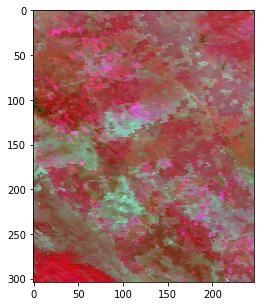

In [5]:
import rasterio
import matplotlib.pyplot as plot
import numpy as np

def normalize(band):
    return (band - band.min()) / (band.max() - band.min() + 1e-5)

def img_plot(path):
    with rasterio.open(path) as src:
        img = src.read()
        img = np.nan_to_num(img, nan=0.0)
        
        red = normalize(img[3]) 
        gre = normalize(img[2]) 
        blue = normalize(img[1])  
        rgb = np.stack([red, gre, blue], axis=-1)

        plot.figure(figsize=(15,5))
        plot.imshow(rgb)
        plot.show()

path = df_2018.iloc[0]['path']
img_plot(path)

**Data cleaning and preprocessing**

In [6]:
import os
import zipfile
import rasterio
import numpy as np
from tqdm import tqdm

def resize(img, target_shape=(351, 303)):
    bands, h, w = img.shape
    th, tw = target_shape

    top_crop = max((h - th) // 2, 0)
    left_crop = max((w - tw) // 2, 0)
    img = img[:, top_crop:top_crop+th, left_crop:left_crop+tw]

    pad_h = max(th - img.shape[1], 0)
    pad_w = max(tw - img.shape[2], 0)
    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left

    return np.pad(img, ((0, 0), (pad_top, pad_bottom), (pad_left, pad_right)), mode='constant')


In [ ]:
import os
import numpy as np
import rasterio
from tqdm import tqdm

def clean_and_preprocess(df_year,
                         year_label,
                         target_shape=(351, 303),
                         output_dir="/projects/academic/courses/cse676s25/swetasah/DL Project/preprocessed_images"):
    output_path = os.path.join(output_dir, year_label)
    os.makedirs(output_path, exist_ok=True)

    valid_count, skipped_count = 0, 0

    for _, row in tqdm(df_year.iterrows(),
                       total=len(df_year),
                       desc=f"Processing {year_label}"):
        fire_id   = row['fire_id']
        date_str  = row['date'].strftime('%Y-%m-%d')
        tiff_path = row['path']

        try:
            # open directly from filesystem
            with rasterio.open(tiff_path) as src:
                # require exactly 23 bands
                if src.count != 23:
                    skipped_count += 1
                    continue

                img = src.read()
                nan_ratio = np.isnan(img).sum() / img.size

                # skip if too many NaNs
                if nan_ratio > 0.5:
                    skipped_count += 1
                    continue

                # replace NaNs, clamp negatives
                img = np.nan_to_num(img, nan=0.0)
                img = np.clip(img, a_min=0, a_max=None)

                # skip if entirely zero
                if np.all(img == 0):
                    skipped_count += 1
                    continue

                # crop/pad to target size
                aligned = resize(img, target_shape)

                # save as .npy
                fire_folder = os.path.join(output_path, fire_id)
                os.makedirs(fire_folder, exist_ok=True)
                save_path = os.path.join(fire_folder, f"{date_str}.npy")
                np.save(save_path, aligned)
                valid_count += 1

        except Exception as e:
            # any read/IO error: skip
            skipped_count += 1
            continue

    print(f"{year_label} done — saved: {valid_count}, skipped: {skipped_count}")

In [8]:
clean_and_preprocess(df_2018, "2018")
clean_and_preprocess(df_2019, "2019")
clean_and_preprocess(df_2020, "2020")
clean_and_preprocess(df_2021, "2021")

Processing 2018: 100%|██████████| 3773/3773 [07:19<00:00,  8.58it/s]


2018 done — saved: 3773, skipped: 0


Processing 2019: 100%|██████████| 1425/1425 [02:53<00:00,  8.21it/s]


2019 done — saved: 1425, skipped: 0


Processing 2020:  20%|█▉        | 841/4292 [01:50<05:59,  9.61it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Processing 2021: 100%|██████████| 4117/4117 [07:48<00:00,  8.79it/s]

2021 done — saved: 4117, skipped: 0


**Stats of processed data**

In [9]:
import os
import numpy as np

def processed_stats(path):
    img = np.load(path)
    
    stats = {
        "shape": img.shape,
        "min": float(np.min(img)),
        "max": float(np.max(img)),
        "mean": float(np.mean(img)),
        "std": float(np.std(img)),
        "zero_ratio": float(np.sum(img == 0) / img.size)
    }
    return stats

main = "/projects/academic/courses/cse676s25/swetasah/DL Project/preprocessed_images/2018"
fires = os.listdir(main)[:3]  

for i in fires:
    fire_path = os.path.join(main, i)
    fire_files = sorted(os.listdir(fire_path))[:2] 
    
    for f in fire_files:
        path = os.path.join(fire_path, f)
        print(f"\n{i} | {f}")
        
        stats = processed_stats(path)
        for k, v in stats.items():
            print(f" {k}: {v}")


fire_21458798 | 2018-01-01.npy
 shape: (23, 351, 303)
 min: 0.0
 max: 9577.0
 mean: 398.49102783203125
 std: 931.8948364257812
 zero_ratio: 0.4026602957583012

fire_21458798 | 2018-01-02.npy
 shape: (23, 351, 303)
 min: 0.0
 max: 9577.0
 mean: 708.2575073242188
 std: 1717.3690185546875
 zero_ratio: 0.39053700985111517

fire_21458801 | 2018-01-25.npy
 shape: (23, 351, 303)
 min: 0.0
 max: 8789.0
 mean: 448.0985107421875
 std: 857.6573486328125
 zero_ratio: 0.31708310184418664

fire_21458801 | 2018-01-26.npy
 shape: (23, 351, 303)
 min: 0.0
 max: 8739.0
 mean: 517.0399780273438
 std: 988.6417846679688
 zero_ratio: 0.30672465239835023

fire_21458806 | 2018-01-12.npy
 shape: (23, 351, 303)
 min: 0.0
 max: 9988.0
 mean: 575.6929321289062
 std: 1430.4210205078125
 zero_ratio: 0.41671521295570657

fire_21458806 | 2018-01-13.npy
 shape: (23, 351, 303)
 min: 0.0
 max: 9988.0
 mean: 711.9537353515625
 std: 1799.932373046875
 zero_ratio: 0.3956115789951347


**Visualizing the processed images**


2018, random fire choosen: fire_21997775


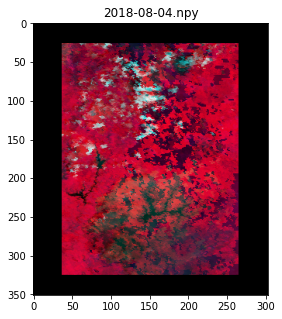

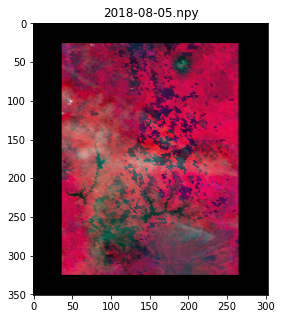

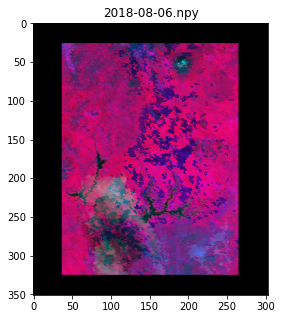


2019, random fire choosen: fire_23300669


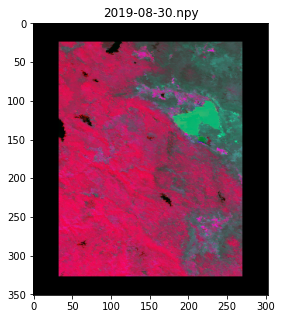

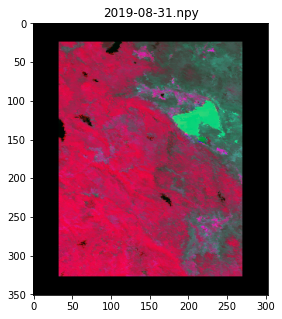

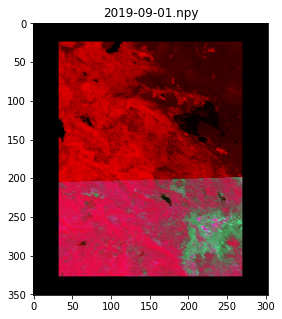


2020, random fire choosen: fire_24332803


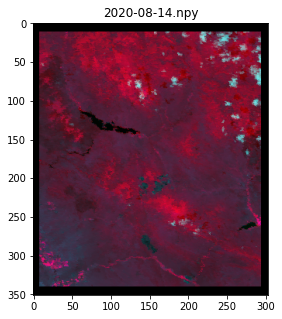

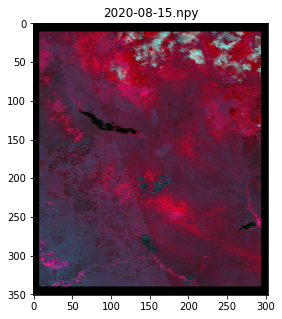

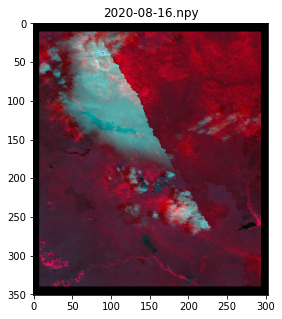


2021, random fire choosen: fire_25411013


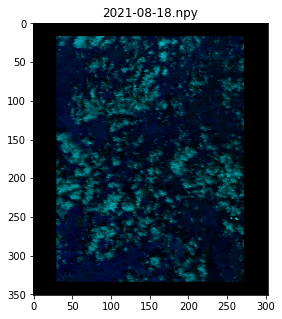

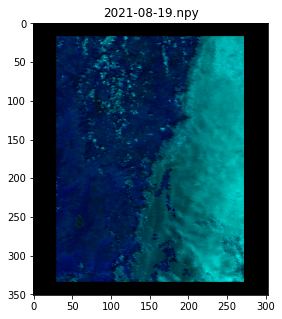

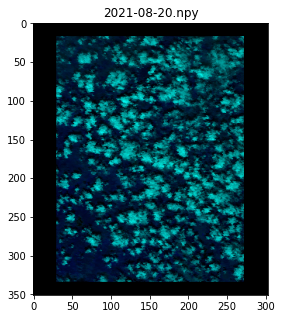

In [10]:
import random
import os
import numpy as np
import matplotlib.pyplot as plot

def normalize(band):
    return (band - band.min()) / (band.max() - band.min() + 1e-5)

def plot_yrs(path):
    img = np.load(path)
    
    red = normalize(img[3])  
    gre = normalize(img[2])  
    blue = normalize(img[1]) 
    rgb = np.stack([red, gre, blue], axis=-1)
    
    plot.figure(figsize=(10, 5))
    plot.imshow(rgb)
    plot.title(f"{os.path.basename(path)}")
    plot.show()

def years_files(year):
   
    year_files = f"/projects/academic/courses/cse676s25/swetasah/DL Project/preprocessed_images/{year}"
    
    if not os.path.exists(year_files):
        print(f"no folder {year} at {year_files}")
        return

    folders = os.listdir(year_files)
    
    if not folders:
        print(f"No fire data in {year}")
        return

    random_fire = random.choice(folders)
    
    print(f"\n{year}, random fire choosen: {random_fire}")

    fire_path = os.path.join(year_files, random_fire)
    
    imgs = sorted([f for f in os.listdir(fire_path) if f.endswith('.npy')])
    if not imgs:
        print(f"No files found in {fire_path}")
        return

    for i in imgs[:3]:
        plot_yrs(os.path.join(fire_path, i))

for year in ["2018","2019", "2020", "2021"]:
    years_files(year)


**Checking images per year**

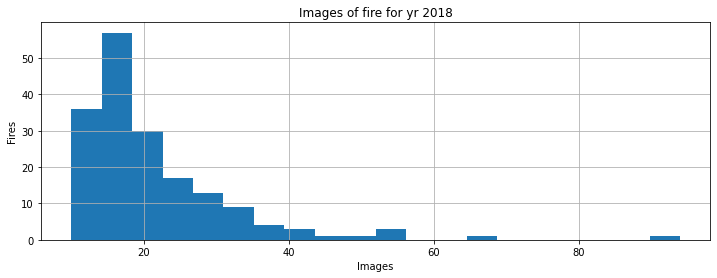

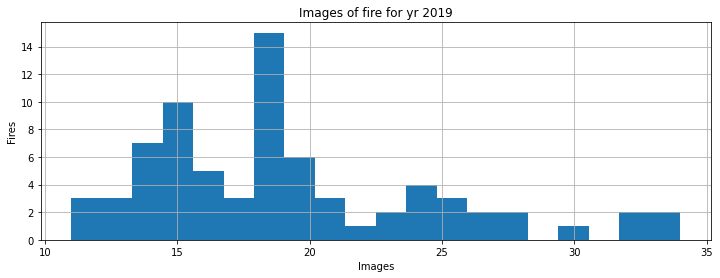

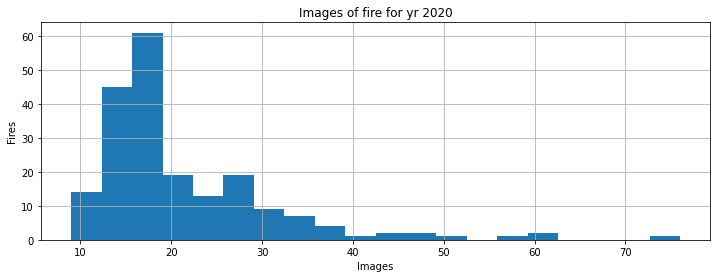

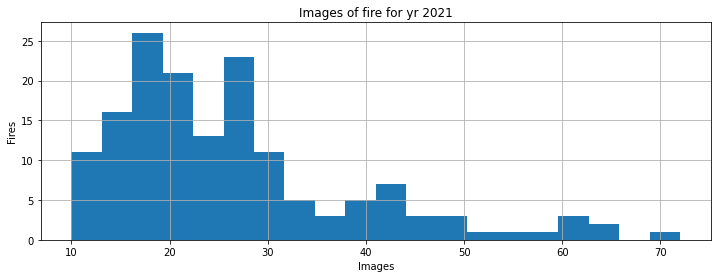

In [11]:
import matplotlib.pyplot as plot

def plotting_gr(df_year, year_label):
    
    numbers = df_year['fire_id'].value_counts()

    plot.figure(figsize=(12, 4))
    
    numbers.hist(bins=20)
    
    plot.title(f"Images of fire for yr {year_label}")
    plot.xlabel("Images")
    plot.ylabel("Fires")
    plot.grid(True)
    plot.show()
    
plotting_gr(df_2018, "2018")
plotting_gr(df_2019, "2019")
plotting_gr(df_2020, "2020")
plotting_gr(df_2021, "2021")

#### Model

In [12]:
import os
import glob
import random
from collections import Counter

import numpy as np
import pandas as pd
import rasterio
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split

In [13]:
# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

# constants
ROOT_DIR = "/projects/academic/courses/cse676s25/swetasah/DL Project/preprocessed_images"
YEARS = ["2018","2019","2020","2021"]
INPUT_BANDS = list(range(23))
INPUT_BANDS_1B = [b+1 for b in INPUT_BANDS]
REFLECT_SCALE = 1e4
BATCH_SIZE = 4
LR = 1e-4
EPOCHS = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
records, shape_counts = [], Counter()
for yr in YEARS:
    year_dir = os.path.join(ROOT_DIR, yr)
    for fid in os.listdir(year_dir):
        fire_dir = os.path.join(year_dir, fid)
        if not os.path.isdir(fire_dir): 
            continue
        # look for .npy instead of .tif
        npys = sorted(glob.glob(os.path.join(fire_dir, "*.npy")))
        # build (t → t+1) record list
        for i in range(len(npys) - 1):
            records.append({
                "inp": npys[i],
                "tgt": npys[i+1],
                "fire_id": fid
            })
        # measure shapes
        for f in npys:
            arr = np.load(f)             # shape = (23, H0, W0)
            _, h, w = arr.shape
            shape_counts[(h, w)] += 1

# now build DataFrame
df = pd.DataFrame(records)
if len(shape_counts) == 0:
    raise RuntimeError(f"No .npy files found under {ROOT_DIR}")

In [15]:
# pick the most common shape and crop to multiple of 224
(raw_h, raw_w), _ = shape_counts.most_common(1)[0]
CS = 4 * (2**3) * 7    # Swin‑V2 requirement
H = raw_h - (raw_h % CS)
W = raw_w - (raw_w % CS)
IMG_SIZE = (H, W)
print(f"Using IMG_SIZE = {IMG_SIZE}   (from raw {(raw_h, raw_w)})")

Using IMG_SIZE = (224, 224)   (from raw (351, 303))


In [16]:
# split by fire_id
fids = df.fire_id.unique()
train_ids, tmp_ids = train_test_split(fids, test_size=0.30, random_state=SEED)
val_ids, test_ids = train_test_split(tmp_ids, test_size=0.50, random_state=SEED)
print(f"Train {len(train_ids)}, Val {len(val_ids)}, Test {len(test_ids)}")

Train 424, Val 91, Test 92


In [17]:
# dataset now reads .npy
class NextDayFireDataset(Dataset):
    def __init__(self, df, ids):
        self.sub = df[df.fire_id.isin(ids)].reset_index(drop=True)
    def __len__(self):
        return len(self.sub)
    def __getitem__(self, idx):
        r = self.sub.iloc[idx]
        arr0 = np.load(r.inp)          # (23, H0, W0)
        arr1 = np.load(r.tgt)          # (23, H0, W0)
        # normalize
        x = torch.from_numpy(arr0 / REFLECT_SCALE).float()
        y = torch.from_numpy(arr1 / REFLECT_SCALE).float()
        # resize to IMG_SIZE
        x = F.interpolate(x.unsqueeze(0), size=IMG_SIZE, mode="bilinear", align_corners=False)[0]
        y = F.interpolate(y.unsqueeze(0), size=IMG_SIZE, mode="bilinear", align_corners=False)[0]
        return x, y

train_ds = NextDayFireDataset(df, train_ids)
val_ds = NextDayFireDataset(df, val_ids)
test_ds = NextDayFireDataset(df, test_ids)

train_loader = DataLoader(train_ds, BATCH_SIZE, sampler=SubsetRandomSampler(range(len(train_ds))), num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, BATCH_SIZE, sampler=SubsetRandomSampler(range(len(val_ds))), num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, BATCH_SIZE, sampler=SubsetRandomSampler(range(len(test_ds))), num_workers=2, pin_memory=True)

In [18]:
!git clone https://github.com/chaineypung/Pytorch-Swin-Unet-V2.git
!mv Pytorch-Swin-Unet-V2/network .
!rm -rf Pytorch-Swin-Unet-V2

Cloning into 'Pytorch-Swin-Unet-V2'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 39 (delta 15), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (39/39), 117.61 KiB | 3.01 MiB/s, done.
Resolving deltas: 100% (15/15), done.
mv: cannot move 'Pytorch-Swin-Unet-V2/network' to './network': File exists


In [14]:
!pip install einops timm

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 64 kB 521 kB/s eta 0:00:011
     |████████████████████████████████| 2.4 MB 3.6 MB/s eta 0:00:01
     |████████████████████████████████| 471 kB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 481 kB 3.6 MB/s eta 0:00:01
     |████████████████████████████████| 194 kB 2.6 MB/s eta 0:00:01
You should consider upgrading via the '/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/Compiler/gcccore/11.2.0/python/3.9.6/bin/python3.9 -m pip install --upgrade pip' command.


In [19]:
import sys
sys.path.insert(0, "network")

from swin_unet_v2 import SwinTransformerSys

# metric on fire band
def compute_metrics(P, T):
    tp = ((P==1)&(T==1)).sum(); tn = ((P==0)&(T==0)).sum()
    fp = ((P==1)&(T==0)).sum(); fn = ((P==0)&(T==1)).sum()
    acc = (tp+tn)/(tp+tn+fp+fn+1e-8)
    iou = tp/(tp+fp+fn+1e-8)
    prec=tp/(tp+fp+1e-8); rec=tp/(tp+fn+1e-8)
    f1 = 2*prec*rec/(prec+rec+1e-8)
    return acc, iou, prec, rec, f1

# instantiate
model = SwinTransformerSys(
    img_size=IMG_SIZE[0],
    patch_size=4,
    in_chans=23,
    num_classes=23,
    embed_dim=96,
    depths=[2,2,2,2],
    depths_decoder=[1,2,2,2],
    num_heads=[3,6,12,24],
    window_size=7,
    mlp_ratio=4.0,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    drop_path_rate=0.1,
    norm_layer=nn.LayerNorm,
    final_upsample="expand_first"
).to(DEVICE)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

/user/swetasah/.local/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/MPI/gcc/11.2.0/openmpi/4.1.1/pytorch/1.13.1-CUDA-11.8.0/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /var/tmp/aebruno2/easybuild/build/PyTorch/1.13.1/foss-2021b-CUDA-11.8.0/pytorch-v1.13.1/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:23
---final upsample expand_first---


In [20]:
# TRAIN & VALIDATE
best_val = float("inf")
for ep in range(1, EPOCHS+1):
    model.train(); tr_loss=0.
    for x,y in tqdm(train_loader, desc=f"Train {ep}/{EPOCHS}"):
        x,y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss= criterion(out, y)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        tr_loss+= loss.item()
    model.eval(); val_loss=0.; fire_P=[]; fire_T=[]
    with torch.no_grad():
        for x,y in tqdm(val_loader, desc=f"Val {ep}/{EPOCHS}"):
            x,y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            val_loss += criterion(out, y).item()
    avg_val= val_loss/len(val_loader)
    print(f"Epoch:{ep}, Train loss: {tr_loss/len(train_loader):.4f}, Val loss: {avg_val:.4f}")
    if avg_val<best_val:
        best_val=avg_val
        torch.save(model.state_dict(), "best_swin_v2.pth")

Val 1/5: 100%|██████████| 490/490 [00:56<00:00,  8.60it/s]


Epoch:1, Train loss: 0.0046, Val loss: 0.0028


Train 2/5:  90%|█████████ | 2028/2252 [04:38<00:29,  7.70it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Val 5/5: 100%|██████████| 490/490 [00:58<00:00,  8.42it/s]


Epoch:5, Train loss: 0.0027, Val loss: 0.0025


In [ ]:
# load best
model.load_state_dict(torch.load("best_swin_v2.pth", map_location=DEVICE))
model.eval()

# test metrics
fire_P, fire_T = [], []
with torch.no_grad():
    for x,y in tqdm(test_loader, desc="Test Eval"):
        x,y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        Pf = (out[:,0]>0).cpu().numpy().ravel().astype(np.uint8)
        Tf = (y[:,0]>0).cpu().numpy().ravel().astype(np.uint8)
        fire_P.append(Pf); fire_T.append(Tf)
P_all = np.concatenate(fire_P); T_all = np.concatenate(fire_T)
acc,iou,prec,rec,f1 = compute_metrics(P_all, T_all)
print(f"Test accuracy: {acc:.4f}, IoU: {iou:.4f}, F1: {f1:.4f}")

Test Eval: 100%|██████████| 509/509 [00:59<00:00,  8.50it/s]


TEST: Acc=0.9185, IoU=0.8977, F1=0.9461


Hyperparameter Tuning
=========

In [ ]:
import optuna
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm

import sys
sys.path.insert(0, "network")
from swin_unet_v2 import SwinTransformerSys

def objective(trial):
    lr = trial.suggest_loguniform("lr", 1e-6, 1e-4)
    wd = trial.suggest_loguniform("weight_decay", 1e-6, 1e-2)
    dpr = trial.suggest_uniform("drop_path_rate", 0.0, 0.3)

    model = SwinTransformerSys(
        img_size=IMG_SIZE[0],
        patch_size=4,
        in_chans=23,
        num_classes=23,
        embed_dim=96,
        depths=[2,2,2,2],
        depths_decoder=[1,2,2,2],
        num_heads=[3,6,12,24],
        window_size=7,
        mlp_ratio=4.0,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=dpr,
        norm_layer=nn.LayerNorm,
        final_upsample="expand_first"
    ).to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.MSELoss()

    N_EPOCHS = 3
    for ep in range(1, N_EPOCHS+1):
        # training 
        model.train()
        tr_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            tr_loss += loss.item()
        tr_loss /= len(train_loader)

        # validation 
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                val_loss += criterion(model(x), y).item()
        val_loss /= len(val_loader)

        print(f"[Setup {trial.number:2d}], Epoch {ep:>2}/{N_EPOCHS}"
              f"Train Loss: {tr_loss:.4f}, Val Loss: {val_loss:.4f}")

    return val_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20, timeout=60*30)

print("Best val loss:", study.best_value)
print("Best hyperparams:", study.best_params)

[I 2025-04-20 15:48:40,625] A new study created in memory with name: no-name-c6d6b4af-a7a0-4c63-98b7-abb1c378f07b
/scratch/19419658/ipykernel_2560075/3184713846.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-6, 1e-4)
/scratch/19419658/ipykernel_2560075/3184713846.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform("weight_decay", 1e-6, 1e-2)
/scratch/19419658/ipykernel_2560075/3184713846.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dpr = trial.sug

SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.26051585533999305;num_classes:23
---final upsample expand_first---
[Setup  0], Epoch  1/3Train Loss: 0.0055, Val Loss: 0.0032
[Setup  0], Epoch  2/3Train Loss: 0.0031, Val Loss: 0.0028


[I 2025-04-20 16:08:17,786] Trial 0 finished with value: 0.0025510873658017123 and parameters: {'lr': 5.694859793351737e-05, 'weight_decay': 2.9845730976986945e-06, 'drop_path_rate': 0.26051585533999305}. Best is trial 0 with value: 0.0025510873658017123.


[Setup  0], Epoch  3/3Train Loss: 0.0029, Val Loss: 0.0026
SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.020766995931363663;num_classes:23
---final upsample expand_first---
[Setup  1], Epoch  1/3Train Loss: 0.0061, Val Loss: 0.0031
[Setup  1], Epoch  2/3Train Loss: 0.0033, Val Loss: 0.0035


[I 2025-04-20 16:28:34,127] Trial 1 finished with value: 0.002834279787826485 and parameters: {'lr': 4.01790876572869e-05, 'weight_decay': 0.00842996524495916, 'drop_path_rate': 0.020766995931363663}. Best is trial 0 with value: 0.0025510873658017123.


[Setup  1], Epoch  3/3Train Loss: 0.0032, Val Loss: 0.0028
Best val loss: 0.0025510873658017123
Best hyperparams: {'lr': 5.694859793351737e-05, 'weight_decay': 2.9845730976986945e-06, 'drop_path_rate': 0.26051585533999305}


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from swin_unet_v2 import SwinTransformerSys
import numpy as np

EPOCHS = 10

best_params = study.best_params
lr  = best_params["lr"]
wd  = best_params["weight_decay"]
dpr = best_params["drop_path_rate"]

print(f"Using tuned paramsz: lr={lr:.2e}, weight_decay={wd:.2e}, drop_path_rate={dpr:.2f}")

def compute_metrics(P, T):
    tp = ((P==1)&(T==1)).sum()
    tn = ((P==0)&(T==0)).sum()
    fp = ((P==1)&(T==0)).sum()
    fn = ((P==0)&(T==1)).sum()
    acc = (tp+tn)/(tp+tn+fp+fn+1e-8)
    iou = tp/(tp+fp+fn+1e-8)
    prec=tp/(tp+fp+1e-8)
    rec =tp/(tp+fn+1e-8)
    f1  =2*prec*rec/(prec+rec+1e-8)
    return acc, iou, prec, rec, f1

model = SwinTransformerSys(
    img_size=IMG_SIZE[0],
    patch_size=4,
    in_chans=23,
    num_classes=23,
    embed_dim=96,
    depths=[2,2,2,2],
    depths_decoder=[1,2,2,2],
    num_heads=[3,6,12,24],
    window_size=7,
    mlp_ratio=4.0,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    drop_path_rate=dpr,
    norm_layer=nn.LayerNorm,
    final_upsample="expand_first"
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
criterion = nn.MSELoss()

best_val = float("inf")
for ep in range(1, EPOCHS+1):
    # training
    model.train()
    tr_loss = 0.0
    for x,y in tqdm(train_loader, desc=f"Train Epoch {ep}/{EPOCHS}"):
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        tr_loss += loss.item()
    tr_loss /= len(train_loader)

    # validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x,y in tqdm(val_loader, desc=f"Valid Epoch {ep}/{EPOCHS}"):
            x, y = x.to(DEVICE), y.to(DEVICE)
            val_loss += criterion(model(x), y).item()
    val_loss /= len(val_loader)

    print(f"Epoch: {ep} Train Loss: {tr_loss:.4f}, Val Loss: {val_loss:.4f}")
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "best_swin_v2_tuned.pth")
        print(f"New best model saved (Val loss={best_val:.4f})")

Using tuned paramsz: lr=5.69e-05, weight_decay=2.98e-06, drop_path_rate=0.26
SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.26051585533999305;num_classes:23
---final upsample expand_first---


Train Epoch 1/10:   0%|          | 0/2252 [00:00<?, ?it/s]

Valid Epoch 1/10:   0%|          | 0/490 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.0055, Val Loss: 0.0039
New best model saved (Val loss=0.0039)


Train Epoch 2/10:   0%|          | 0/2252 [00:20<?, ?it/s]

Valid Epoch 2/10:   0%|          | 0/490 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 0.0031, Val Loss: 0.0027
New best model saved (Val loss=0.0027)


Train Epoch 3/10:   0%|          | 0/2252 [00:00<?, ?it/s]

Valid Epoch 3/10:   0%|          | 0/490 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 0.0029, Val Loss: 0.0025
New best model saved (Val loss=0.0025)


Train Epoch 4/10:   0%|          | 0/2252 [00:10<?, ?it/s]

Valid Epoch 4/10:   0%|          | 0/490 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 0.0028, Val Loss: 0.0025
New best model saved (Val loss=0.0025)


Train Epoch 5/10:   0%|          | 0/2252 [00:10<?, ?it/s]

Valid Epoch 5/10:   0%|          | 0/490 [00:00<?, ?it/s]

Epoch: 5 Train Loss: 0.0027, Val Loss: 0.0026


Train Epoch 6/10:   0%|          | 0/2252 [00:00<?, ?it/s]

Valid Epoch 6/10:   0%|          | 0/490 [00:00<?, ?it/s]

Epoch: 6 Train Loss: 0.0027, Val Loss: 0.0025
New best model saved (Val loss=0.0025)


Train Epoch 7/10:   0%|          | 0/2252 [00:00<?, ?it/s]

Valid Epoch 7/10:   0%|          | 0/490 [00:00<?, ?it/s]

Epoch: 7 Train Loss: 0.0026, Val Loss: 0.0025


Train Epoch 8/10:   0%|          | 0/2252 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
model.load_state_dict(torch.load("best_swin_v2_tuned.pth", map_location=DEVICE))
model.eval()

all_P, all_T = [], []
with torch.no_grad():
    for x,y in tqdm(test_loader, desc="Test Eval"):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        P = (out[:,0]>0).cpu().numpy().ravel().astype(np.uint8)
        T = (y[:,0]>0).cpu().numpy().ravel().astype(np.uint8)
        all_P.append(P); all_T.append(T)

P_all = np.concatenate(all_P)
T_all = np.concatenate(all_T)

acc, iou, prec, rec, f1 = compute_metrics(P_all, T_all)
print("\nTEST METRICS")
print(f"Accuracy : {acc:.4f}")
print(f"IoU : {iou:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")

Test Eval:   0%|          | 0/509 [00:00<?, ?it/s]


TEST METRICS
Accuracy : 0.7202
IoU : 0.7187
Precision : 0.7188
Recall : 0.9999
F1-Score : 0.8363


## Model Inference

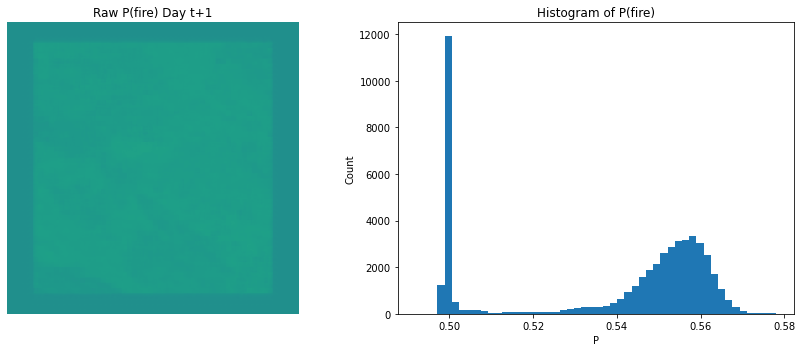

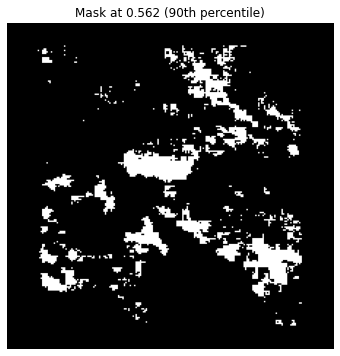

In [ ]:
model.load_state_dict(torch.load("best_swin_v2.pth", map_location=DEVICE))
model.eval()

# Loading sample .npy
sample = "/projects/academic/courses/cse676s25/swetasah/DL Project/preprocessed_images/2018/fire_21458798/2018-01-01.npy"
arr0 = np.load(sample)             # (23, H0, W0)
H0, W0 = arr0.shape[1:]

x0 = torch.from_numpy(arr0/REFLECT_SCALE).unsqueeze(0).to(DEVICE)   # (1,23,H0,W0)
x  = F.interpolate(x0, size=IMG_SIZE, mode="bilinear", align_corners=False)

# inference 
with torch.no_grad():
    logits = model(x)                    # (1,1,H,W)
    fire_p = torch.sigmoid(logits)[0,0].cpu().numpy()  # (H,W)

# crop back to original resolution
fire_p = fire_p[:H0, :W0]

# plotting raw probability map + histogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(fire_p, cmap='viridis', vmin=0, vmax=1)
ax1.set_title("Raw P(fire) Day t+1"); ax1.axis('off')
ax2.hist(fire_p.flatten(), bins=50)
ax2.set_title("Histogram of P(fire)"); ax2.set_xlabel("P"); ax2.set_ylabel("Count")
plt.tight_layout()
plt.show()

# Threshold at the 90th percentile
thr = np.percentile(fire_p.flatten(), 90)
mask2 = (fire_p > thr).astype(np.uint8)
plt.figure(figsize=(6,6))
plt.imshow(mask2, cmap='gray', vmin=0, vmax=1)
plt.title(f"Mask at {thr:.3f} (90th percentile)"); plt.axis('off')
plt.show()

In [ ]:
import numpy as np
from tqdm.auto import tqdm
import torch

def find_best_percentile(val_loader, model, device):
    percentiles = np.linspace(80, 99, 20)
    avg_area_errors = []

    all_probs   = []
    true_counts = []
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(val_loader, desc="Collect val probs"):
            x = x.to(device)
            logit0 = model(x)[:,0]              # (B,H,W)
            probs  = torch.sigmoid(logit0).cpu().numpy()
            all_probs.append(probs.reshape(-1))
            true_counts.append((y[:,0].numpy() > 0).sum())

    all_probs   = np.concatenate(all_probs)  
    true_counts = np.array(true_counts)       

    for p in percentiles:
        τ = np.percentile(all_probs, p)
        pred_counts = []
        idx = 0
        batch_sizes = [x.shape[0] * x.shape[2] * x.shape[3] for x,_ in val_loader]
        for bs in batch_sizes:
            chunk = all_probs[idx:idx+bs]
            pred_counts.append((chunk > τ).sum())
            idx += bs

        # mean absolute error in area (pixels)
        mae = np.mean(np.abs(np.array(pred_counts) - true_counts))
        avg_area_errors.append(mae)

    best_i = np.argmin(avg_area_errors)
    best_percentile = percentiles[best_i]
    best_tau = np.percentile(all_probs, best_percentile)
    return best_percentile, best_tau

best_p, global_tau = find_best_percentile(val_loader, model, DEVICE)
print(f"best percentile = {best_p:.1f} τ = {global_tau:.4f}")

Collect val probs:   0%|          | 0/490 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x143d8c6f7b80>
Traceback (most recent call last):
  File "/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/MPI/gcc/11.2.0/openmpi/4.1.1/pytorch/1.13.1-CUDA-11.8.0/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
  File "/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/MPI/gcc/11.2.0/openmpi/4.1.1/pytorch/1.13.1-CUDA-11.8.0/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
  File "/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/Compiler/gcccore/11.2.0/python/3.9.6/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x143d8c6f7b80>
Traceback (most recent call last):
  File "/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx51

best percentile = 80.0 τ = 0.5546


P(fire) range: 0.48442557 0.582318


(-0.5, 223.5, 223.5, -0.5)

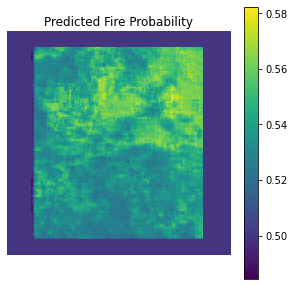

In [31]:
with torch.no_grad():
    logits = model(x)               # (1,1,H,W)
    probs = torch.sigmoid(logits)[0,0].cpu().numpy()  # [0,1]

print("P(fire) range:", probs.min(), probs.max())

plt.figure(figsize=(5,5))
plt.imshow(probs, cmap='viridis')
plt.title("Predicted Fire Probability")
plt.colorbar();
plt.axis('off')

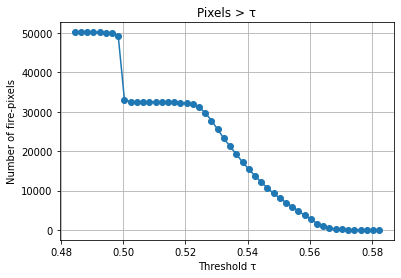

Selected τ = 0.546 gives ~10620 pixels → 9.56 km²


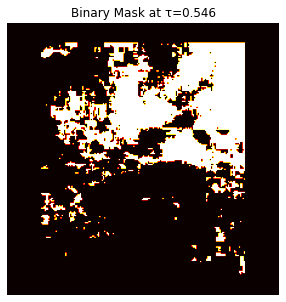

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

ths = np.linspace(probs.min(), probs.max(), 50)
counts = [(probs > t).sum() for t in ths]

# Plot threshold vs. number of fire‐pixels
plt.figure(figsize=(6,4))
plt.plot(ths, counts, marker='o')
plt.xlabel("Threshold τ")
plt.ylabel("Number of fire‐pixels")
plt.title("Pixels > τ")
plt.grid(True)
plt.show()

pixel_area_m2 = 30 * 30
desired_area_km2 = 10.0        
desired_pixels = desired_area_km2 * 1e6 / pixel_area_m2

idx = np.argmin(np.abs(np.array(counts) - desired_pixels))
tau = ths[idx]
print(f"Selected τ = {tau:.3f} gives ~{counts[idx]} pixels → "
      f"{counts[idx]*pixel_area_m2/1e6:.2f} km²")

# hard mask
hard_mask = (probs > tau).astype(np.uint8)

# Plot the final binary mask
plt.figure(figsize=(5,5))
plt.imshow(hard_mask, cmap="hot", vmin=0, vmax=1)
plt.title(f"Binary Mask at τ={tau:.3f}")
plt.axis("off")
plt.show()

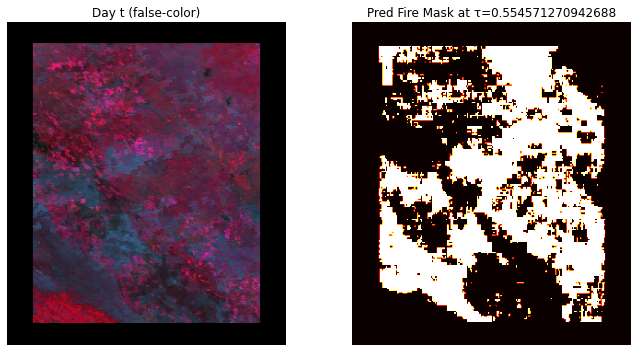

In [ ]:
# Inference on one sample
x0  = torch.from_numpy(arr0/REFLECT_SCALE).unsqueeze(0).to(DEVICE)   # (1,23,H0,W0)
x   = F.interpolate(x0, size=IMG_SIZE, mode="bilinear", align_corners=False)

with torch.no_grad():
    out23 = model(x)             # (1,23,H,W)
    fire_logits = out23[:,0]     
    fire_probs  = torch.sigmoid(fire_logits)[0].cpu().numpy()

# Threshold for a hard fire‐mask
hard_mask = (fire_probs > global_tau).astype(np.uint8)

# Upsample back to original H0×W0
mask_up = F.interpolate(torch.from_numpy(hard_mask[None,None]).float(),
                       size=(H0,W0), mode="nearest")[0,0].numpy().astype(np.uint8)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.imshow(np.clip(np.moveaxis(arr0[[3,2,1]]/REFLECT_SCALE,0,-1),0,1))
ax1.set_title("Day t (false-color)"); ax1.axis("off")
ax2.imshow(mask_up, cmap="hot", vmin=0, vmax=1)
ax2.set_title(f"Pred Fire Mask at τ={global_tau}")
ax2.axis("off")
plt.tight_layout(); plt.show()

SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:23
---final upsample expand_first---


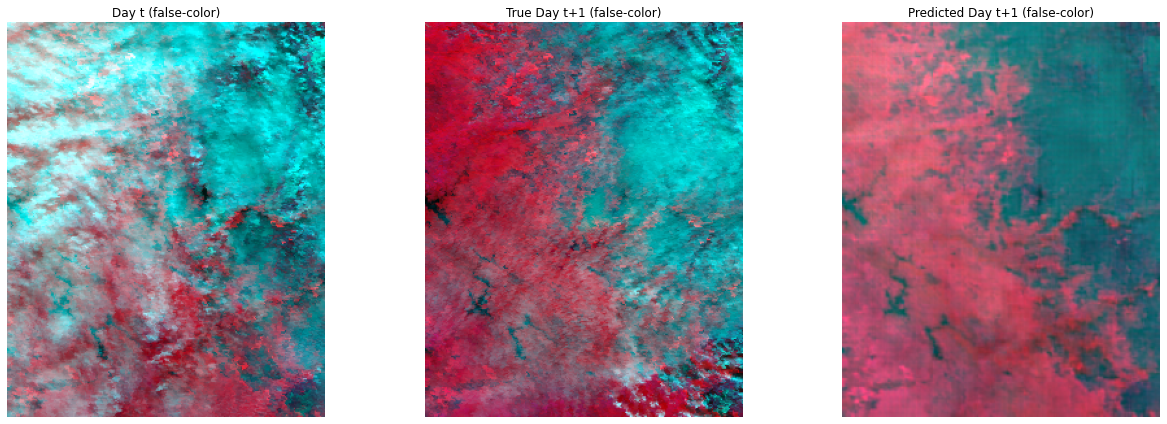

In [ ]:
from datetime import datetime, timedelta
import os

import numpy as np
import rasterio
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from swin_unet_v2 import SwinTransformerSys
model = SwinTransformerSys(
    img_size=IMG_SIZE[0],
    patch_size=4,
    in_chans=23,
    num_classes=23,
    embed_dim=96,
    depths=[2,2,2,2],
    depths_decoder=[1,2,2,2],
    num_heads=[3,6,12,24],
    window_size=7,
    mlp_ratio=4.0,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    drop_path_rate=0.1,
    norm_layer=torch.nn.LayerNorm,
    final_upsample="expand_first",
).to(DEVICE)
model.load_state_dict(torch.load("best_swin_v2.pth", map_location=DEVICE))
model.eval()

TAU      = global_tau
INPUT_1B = INPUT_BANDS_1B  # [1..23]

sample_t  = "/projects/academic/courses/cse676s25/swetasah/DL Project/dataset/WildfireSpreadTS/2021/fire_24935867/2021-02-02.tif"
dt         = datetime.strptime(os.path.basename(sample_t)[:-4], "%Y-%m-%d")
sample_t1  = os.path.join(os.path.dirname(sample_t), (dt + timedelta(days=1)).strftime("%Y-%m-%d") + ".tif")

with rasterio.open(sample_t) as src:
    arr0 = src.read(INPUT_1B)   # (23, H0, W0)
with rasterio.open(sample_t1) as src:
    arr1 = src.read(INPUT_1B)   # (23, H0, W0)
H0, W0 = arr0.shape[1:]

# model input from Day t
x0 = torch.from_numpy(np.nan_to_num(arr0)/REFLECT_SCALE)\
        .unsqueeze(0).float().to(DEVICE)      # (1,23,H0,W0)
x  = F.interpolate(x0, size=IMG_SIZE, mode="bilinear", align_corners=False)

with torch.no_grad():
    out23 = model(x)                       # (1,23,H,W)
pred   = F.interpolate(out23, size=(H0,W0),
                       mode="bilinear", align_corners=False)[0]  # (23, H0, W0)
pred   = pred.cpu().numpy() * REFLECT_SCALE                        

# false‑color RGBs (bands 4,3,2)
def make_rgb(cube):
    rgb = np.clip(np.moveaxis(cube[[3,2,1]]/REFLECT_SCALE, 0, -1), 0,1)
    return rgb

rgb_t     = make_rgb(arr0)   # Day t
rgb_true  = make_rgb(arr1)   # True Day t+1
rgb_pred  = make_rgb(pred)   # Predicted Day t+1

fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(18,6))

ax0.imshow(rgb_t)
ax0.set_title("Day t (false-color)")
ax0.axis("off")

ax1.imshow(rgb_true)
ax1.set_title("True Day t+1 (false-color)")
ax1.axis("off")

ax2.imshow(rgb_pred)
ax2.set_title("Predicted Day t+1 (false-color)")
ax2.axis("off")

plt.tight_layout()
plt.show()

## Inference on a random test sample 

Day t TIFF: /projects/academic/courses/cse676s25/swetasah/DL Project/dataset/WildfireSpreadTS/2021/fire_25295909/2021-07-17.tif
Day t+1 TIFF: /projects/academic/courses/cse676s25/swetasah/DL Project/dataset/WildfireSpreadTS/2021/fire_25295909/2021-07-18.tif
SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:23
---final upsample expand_first---


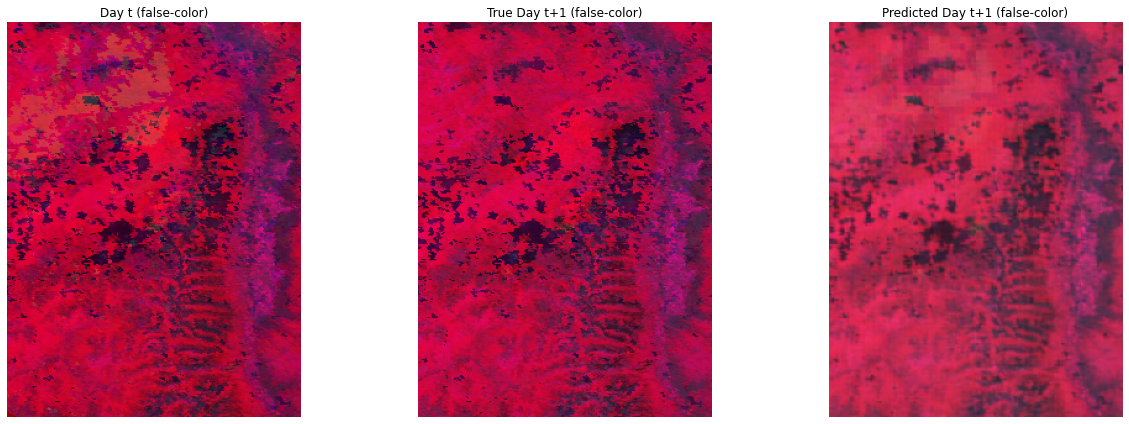

In [ ]:
import random
from datetime import datetime, timedelta
import os

import numpy as np
import rasterio
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# checking for a random test sample 
random.seed(42)
sample = df[df.fire_id.isin(test_ids)].sample(1).iloc[0]
npy_in = sample["inp"]   
npy_t1 = sample["tgt"]

tif_in  = npy_in.replace("preprocessed_images", "dataset/WildfireSpreadTS").replace(".npy", ".tif")
tif_t1  = npy_t1.replace("preprocessed_images", "dataset/WildfireSpreadTS").replace(".npy", ".tif")

print("Day t TIFF:", tif_in)
print("Day t+1 TIFF:", tif_t1)


# Read raw Day t & Day t+1 for false‑color
INPUT_1B = [i+1 for i in range(23)]
REFLECT_SCALE = 1e4

with rasterio.open(tif_in) as src:
    arr0 = src.read(INPUT_1B)   # (23, H0, W0)
with rasterio.open(tif_t1) as src:
    arr1 = src.read(INPUT_1B)   # (23, H0, W0)
H0, W0 = arr0.shape[1:]

def make_rgb(cube):
    rgb = np.clip(np.moveaxis(cube[[3,2,1]]/REFLECT_SCALE, 0, -1), 0,1)
    return rgb

rgb_t    = make_rgb(arr0)
rgb_true = make_rgb(arr1)

from swin_unet_v2 import SwinTransformerSys
model23 = SwinTransformerSys(
    img_size=IMG_SIZE[0],
    patch_size=4,
    in_chans=23,
    num_classes=23,
    embed_dim=96,
    depths=[2,2,2,2],
    depths_decoder=[1,2,2,2],
    num_heads=[3,6,12,24],
    window_size=7,
    mlp_ratio=4.0,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    drop_path_rate=0.1,
    norm_layer=torch.nn.LayerNorm,
    final_upsample="expand_first",
).to(DEVICE)
model23.load_state_dict(torch.load("best_swin_v2.pth", map_location=DEVICE))
model23.eval()

# prepare input
x0 = torch.from_numpy(np.nan_to_num(arr0)/REFLECT_SCALE) \
         .unsqueeze(0).float().to(DEVICE)  # (1,23,H0,W0)
x  = F.interpolate(x0, size=IMG_SIZE, mode="bilinear", align_corners=False)

# inference + upsample
with torch.no_grad():
    out23 = model23(x)                        # (1,23,h,w)
pred   = F.interpolate(out23, size=(H0,W0), 
                       mode="bilinear", align_corners=False)[0]  # (23,H0,W0)
pred   = pred.cpu().numpy() * REFLECT_SCALE                       # to reflectance

rgb_pred = make_rgb(pred)

fig,(ax0,ax1,ax2) = plt.subplots(1,3,figsize=(18,6))

ax0.imshow(rgb_t)
ax0.set_title("Day t (false-color)")
ax0.axis("off")

ax1.imshow(rgb_true)
ax1.set_title("True Day t+1 (false-color)")
ax1.axis("off")

ax2.imshow(rgb_pred)
ax2.set_title("Predicted Day t+1 (false-color)")
ax2.axis("off")

plt.tight_layout()
plt.show()